In [ ]:
 # import google drive and check file 
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [2]:
!pip install --upgrade tensorflow
!pip install keras-tuner --upgrade
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install keras-cv
!pip install tensorflow_addons
!pip install git+https://github.com/qubvel/classification_models.git
!pip install -q tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 438 kB 64.0 MB/s 
     |████████████████████████████████| 1.6 MB 43.5 MB/s 
     |████████████████████████████████| 5.8 MB 26.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [3]:
import keras_cv
from tensorflow.keras.utils import get_source_inputs
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications, losses, optimizers, Model, regularizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, VGG16, MobileNetV3Large, ResNet50V2, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
import PIL
import tempfile
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, StratifiedKFold
import keras_tuner
import cv2
import random
import itertools
import pandas as pd
from classification_models.tfkeras import Classifiers
import tensorflow_model_optimization as tfmot

tf.random.set_seed(123)
np.random.seed(123)


In [ ]:
# %load_ext tensorboard
# import datetime
# # Clear any logs from previous runs
# !rm -rf ./logs/


In [4]:
# !mkdir data
# !unzip /mydrive/VGG/pepsi_mirinda_1.zip -d data/train
# !mkdir data/test
# !unzip /mydrive/VGG/test_2.zip -d data/test
# !mkdir data/valid
# !unzip /mydrive/VGG/valid_3.zip -d data/valid
!mkdir data2
!unzip /mydrive/VGG/train_tiger_crop_mix.zip -d data2/train
!mkdir data2/test
!unzip /mydrive/VGG/test_tiger_crop_ver2.zip -d data2/test

Archive:  /mydrive/VGG/train_tiger_crop_mix.zip
   creating: data2/train/background/
  inflating: data2/train/background/augimg_0_0.png  
  inflating: data2/train/background/augimg_0_1.png  
  inflating: data2/train/background/augimg_0_2.png  
  inflating: data2/train/background/augimg_0_3.png  
  inflating: data2/train/background/augimg_0_4.png  
  inflating: data2/train/background/augimg_0_5.png  
  inflating: data2/train/background/augimg_0_6.png  
  inflating: data2/train/background/augimg_0_7.png  
  inflating: data2/train/background/augimg_0_8.png  
  inflating: data2/train/background/augimg_0_9.png  
  inflating: data2/train/background/augimg_1_0.png  
  inflating: data2/train/background/augimg_1_1.png  
  inflating: data2/train/background/augimg_1_2.png  
  inflating: data2/train/background/augimg_1_3.png  
  inflating: data2/train/background/augimg_1_4.png  
  inflating: data2/train/background/augimg_1_5.png  
  inflating: data2/train/background/augimg_1_6.png  
  inflating: d

In [ ]:
# classes = ['background', 'dat', 'meo', 'sai_nhan']
# lst = []
# for i in classes:
#   path = os.listdir(f'data2/test/{i}')
#   for j in path:
#     lst.append(f'data2/test/{i}/{j}')

In [5]:
batch_size = 64
img_height = 224
img_width = 224

In [7]:
def adjust_gamma(image, gamma=1.8):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

class Randomgamma(keras_cv.layers.BaseImageAugmentationLayer):
    def gamma_aug(self, image, gamma, transformation=None):
      img = adjust_gamma(image, gamma=gamma)
      return img

In [8]:
cut_mix = keras_cv.layers.CutMix(alpha=1.0)
mix_up = keras_cv.layers.MixUp(alpha=0.2)
rand_gamma = Randomgamma()
cut_out = keras_cv.layers.RandomCutout(
    (0.4, 0.4), 
    (0.4, 0.4),
    fill_mode="constant"
)
random_gridmask = keras_cv.layers.preprocessing.GridMask(ratio_factor=(0, 0.4),
                                                         fill_mode="constant"
                                                         )
rand_rotate = tf.keras.layers.RandomRotation(
    factor = (-0.25, 0.25),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=123
)
rand_flip = tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical",
    seed=123
)
rand_brightness = tf.keras.layers.RandomBrightness(
      0.4, 
      value_range=(0, 255), 
      seed=123
  )
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
)
rand_contrast = keras_cv.layers.AutoContrast([0, 225])
rand_shear = keras_cv.layers.RandomShear(
    x_factor=(0, 0.3),
    y_factor=0
)
rand_augment = keras_cv.layers.RandomAugmentationPipeline(                      #Random chọn loại augmentation
    layers=(rand_shear, rand_brightness, rand_flip, cut_out),
    augmentations_per_image=2,
    rate=0.9
)
rand_augment_2 = keras_cv.layers.RandomAugmentationPipeline(
    layers=(rand_shear, rand_brightness, rand_flip),
    augmentations_per_image=2,
    rate=0.9
)
cut_out_2 = keras_cv.layers.RandomCutout(
    (0.1, 0.1), 
    (0.1, 0.1),
    fill_mode="constant"
)
def salt_and_pepper(image, prob_salt=0.1, prob_pepper=0.1):
    random_values = tf.random.uniform(shape=image[0, ..., -1:].shape)
    image = tf.where(random_values < prob_salt, 255., image)
    image = tf.where(1 - random_values < prob_pepper, 0., image)
    return image

In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data2/train',
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  shuffle=True,
  batch_size=batch_size)
valid_ds = tf.keras.utils.image_dataset_from_directory(
  'data2/test',
  label_mode='categorical',
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  seed=123,
  shuffle=False,
  batch_size=batch_size)

Found 1228 files belonging to 4 classes.
Found 406 files belonging to 4 classes.


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
plt.figure(figsize=(10, 10))
class_names = ['background', 'đạt', 'méo', 'sai nhãn']
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(labels[i], axis=0)])
    plt.axis("off")

In [25]:
train_ds = train_ds.map(lambda x, y: {'images': x, 'labels': y})
valid_ds = valid_ds.map(lambda x, y: {'images': x, 'labels': y})
# test_ds = test_ds.map(lambda x, y: {'images': x, 'labels': y})

In [ ]:
# def apply_pre_pos(inputs):
#   # inputs['images'] = tfa.image.gaussian_filter2d(inputs['images'], filter_shape=(5, 5))
#   inputs['images'] = tf.image.adjust_gamma(inputs['images'], gamma=1, gain=111)
#   return inputs
# train_ds = train_ds.map(lambda x: apply_pre_pos(x) if (random.randint(0, 9) > 1) else x)
# # valid_ds = valid_ds.map(lambda x: apply_pre_pos(x))

In [ ]:
def apply_cutmix_augment(inputs):
  inputs = cut_mix(inputs, training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_cutmix_augment(x))

In [ ]:
def apply_mixup_augment(inputs):
  inputs = mix_up(inputs, training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_mixup_augment(x))

In [ ]:
def apply_grid_augment(inputs):
    # inputs["images"] = random_gridmask(inputs["images"], training=True)
    inputs = random_gridmask(inputs, training=True)
    return inputs
train_ds = train_ds.map(lambda x: apply_grid_augment(x))
# valid_ds = valid_ds.map(lambda x: apply_grid_augment(x))

In [ ]:
def apply_rand_augment(inputs):
  # inputs['images'] = rand_aug_bf(inputs['images'], training=True)
  inputs['images'] = rand_augment(inputs['images'], training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_rand_augment(x))
# valid_ds = valid_ds.map(lambda x: apply_rand_augment(x))

In [ ]:
def apply_rand_rotate(inputs):
  inputs['images'] = rand_rotate(inputs['images'], training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_rand_augment(x))
valid_ds = valid_ds.map(lambda x: apply_rand_augment(x))

In [ ]:
def apply_cutout_augment(inputs):
  inputs['images'] = cut_out_2(inputs['images'], training=True)
  return inputs
# train_ds = train_ds.map(lambda x: apply_cutout_augment(x))
valid_ds = valid_ds.map(lambda x: apply_cutout_augment(x))

In [ ]:
def apply_noise_gamma(inputs):
  rd = tf.random.uniform(
    [],
    minval=0.8,
    maxval=1.2,
    dtype=tf.dtypes.float32,
    seed=123
  )
  inputs['images'] = tf.image.adjust_gamma(inputs['images'], rd, 1)
  return inputs
train_ds = train_ds.map(lambda x: apply_noise_gamma(x))

In [ ]:
def apply_noise_gaussian(inputs):
  inputs['images'] = inputs['images']+100*tf.random.normal(shape=tf.shape(inputs['images']),mean=0,stddev=1)
  return inputs
valid_ds = valid_ds.map(lambda x: apply_noise_gaussian(x))

In [ ]:
def apply_noise_saltpepper(inputs):
  inputs['images'] = salt_and_pepper(inputs['images'])
  return inputs
valid_ds = valid_ds.map(lambda x: apply_noise_saltpepper(x))

In [26]:
def apply_vgg16(inputs):                                                                      #Dùng để chạy code lấy features map
  inputs['images'] = tf.keras.applications.vgg16.preprocess_input(inputs['images'])
  return inputs
train_ds = train_ds.map(lambda x: apply_vgg16(x))
valid_ds = valid_ds.map(lambda x: apply_vgg16(x))

In [27]:
train_ds = train_ds.map(lambda inputs: (inputs["images"], inputs["labels"]))
valid_ds = valid_ds.map(lambda inputs: (inputs["images"], inputs["labels"]))


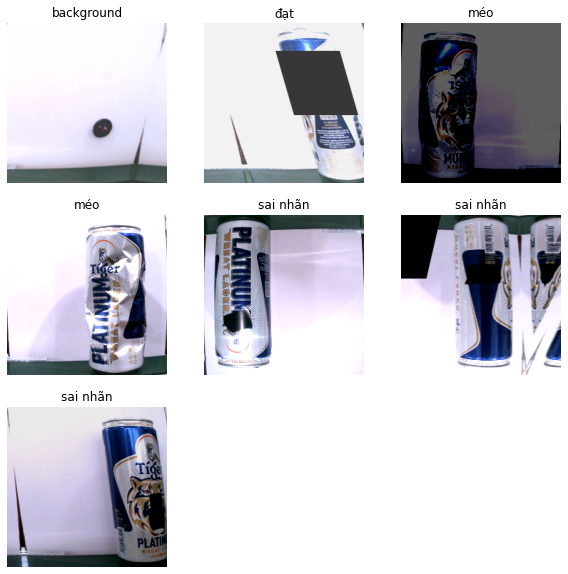

In [ ]:
plt.figure(figsize=(10, 10))
class_names = ['background', 'đạt', 'méo', 'sai nhãn']
i=0
for images in valid_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0][i].numpy().astype(int))
    plt.title(class_names[np.argmax(images[1][i], axis=0)])
    plt.axis("off")
    i +=1

In [13]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0,
                                                              patience=4,
                                                              verbose=1)

In [ ]:
#Dùng khi chạy code lấy features map
checkpoint = ModelCheckpoint('vgg16_check_features.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

VGG16_with_DataAug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in VGG16_with_DataAug.layers:
  if 'block5' in layer.name:
    layer.trainable=True
  else:
    layer.trainable=False
# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = VGG16_with_DataAug.output
x = GlobalAveragePooling2D()(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(160)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Dense(448)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(4, activation='softmax')(x)
VGG16_with_DataAug = Model(inputs=VGG16_with_DataAug.input, outputs=x)

VGG16_with_DataAug.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
                       metrics=["accuracy"])

history_5 = VGG16_with_DataAug.fit(train_ds,
                   epochs=10,
                   validation_data=valid_ds,
                   callbacks=[lr_reduce])

In [30]:
def apply_pruning_to_dense(layer):
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=150)
}
  try:
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  except:
    return layer
model_for_pruning = tf.keras.models.clone_model(
    VGG16_with_DataAug,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds,
                  batch_size=64, epochs=5, validation_data=valid_ds,
                  callbacks=callbacks)

In [ ]:
checkpoint = ModelCheckpoint(f'mobilenetv3_mix_ver2.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
mobile_net = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobile_net.layers:
  if 'conv_10' in layer.name:
    if not isinstance(layer, BatchNormalization):
      layer.trainable=True
    else:
      layer.trainable=False
  else:
    layer.trainable=False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = mobile_net(x)
x = GlobalAveragePooling2D()(x) # Flatten dimensions to for use in FC layers
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(320)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(4, activation='softmax')(x) # Softmax for multiclass
mobile_net = Model(inputs=inputs, outputs=x)

mobile_net.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(lr=0.0008),
                      # optimizer=tfa.optimizers.Yogi(lr=0.0004),
                      metrics=["accuracy"])

history_3 = mobile_net.fit(train_ds,
                   epochs=30,
                   validation_data=valid_ds,
                   callbacks=[lr_reduce, checkpoint])

In [ ]:
checkpoint = ModelCheckpoint('resnet50_mix.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in ResNet50.layers:
    if 'conv5_block3' in layer.name:
      if not isinstance(layer, BatchNormalization):
        layer.trainable=True
      else:
        layer.trainable=False
    else:
      layer.trainable=False
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = ResNet50(x)
x = GlobalAveragePooling2D()(x) 
x = Dense(224)(x)
x = BatchNormalization()(x) 
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(4, activation='softmax')(x)
ResNet50 = Model(inputs=inputs, outputs=x)

ResNet50.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                      # optimizer=tfa.optimizers.Yogi(learning_rate=0.0004),
                       metrics=["accuracy"])

history_4 = ResNet50.fit(train_ds,
                   epochs=100,
                   validation_data=valid_ds,
                   callbacks=[lr_reduce])

In [ ]:
checkpoint = ModelCheckpoint('vgg16_randaug+cutmix.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

VGG16_with_DataAug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in VGG16_with_DataAug.layers:
  if 'block5' in layer.name:
    layer.trainable=True
  else:
    layer.trainable=False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = VGG16_with_DataAug(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(160)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Dense(448)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(4, activation='softmax')(x)
VGG16_with_DataAug = Model(inputs=inputs, outputs=x)

VGG16_with_DataAug.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
                       metrics=["accuracy"])

history_5 = VGG16_with_DataAug.fit(train_ds,
                   epochs=10,
                   validation_data=valid_ds,
                   callbacks=[lr_reduce])

In [ ]:
checkpoint = ModelCheckpoint('vgg16_randaug+mixup.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

VGG16_with_DataAug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in VGG16_with_DataAug.layers:
  if 'block5' in layer.name:
    layer.trainable=True
  else:
    layer.trainable=False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = VGG16_with_DataAug(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(160)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Dense(448)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(4, activation='softmax')(x)
VGG16_with_DataAug = Model(inputs=inputs, outputs=x)

VGG16_with_DataAug.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
                       metrics=["accuracy"])

history_7 = VGG16_with_DataAug.fit(train_ds,
                   epochs=30,
                   validation_data=valid_ds,
                   callbacks=[lr_reduce, checkpoint])

'\nánh sáng 0.5 93%\nánh sáng 0.4 96%\nánh sáng 0.3 97%\nánh sáng 0.2 99%\nánh sáng 0.1 99%\ncutout 0.5 85%\ncutout 0.4 89%\ncutout 0.3 93%\ncutout 0.2 93%\ncutout 0.1 95%\ngaussian 0.01 99% - mean 0 std 1\ngaussian 0.1 99% - mean 0 std 1\ngaussian 1 98% - mean 0 std 1\ngaussian 10 86% - mean 0 std 1\ngaussian 100 43% - mean 0 std 1\nsaltpepper 0.00625 94%\nsaltpepper 0.0125 88%\nsaltpepper 0.025 72%\nsaltpepper 0.05 54%\nsaltpepper 0.1 40%\n\n'

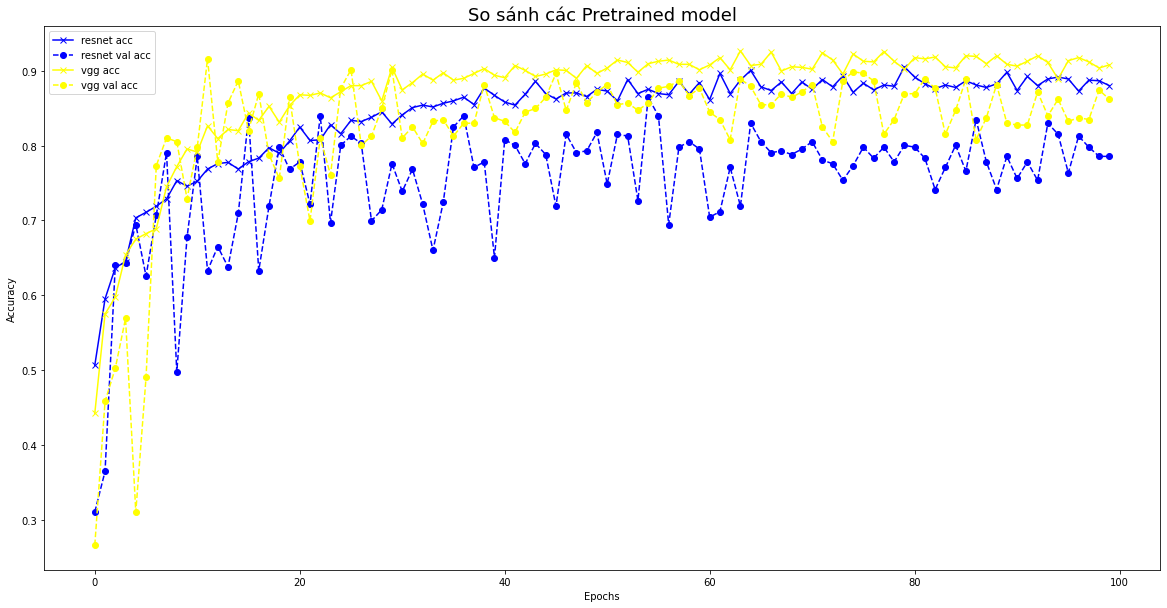

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("So sánh các Pretrained model", fontsize=18)
# plt.plot(history_3.epoch, history_3.history['accuracy'], label = "mobilenet acc", color='red', marker='x')
# plt.plot(history_3.epoch, history_3.history['val_accuracy'], label = "mobilenet valacc", color='red', marker='o', linestyle='dashed')
plt.plot(history_4.epoch, history_4.history['accuracy'], label = "resnet acc", color='blue', marker='x')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], label = "resnet val acc", color='blue', marker='o', linestyle='dashed')
plt.plot(history_5.epoch, history_5.history['accuracy'], label = "vgg acc", color='yellow', marker='x')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], label = "vgg val acc", color='yellow', marker='o', linestyle='dashed')
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

"""
ánh sáng 0.5 93%
ánh sáng 0.4 96%
ánh sáng 0.3 97%
ánh sáng 0.2 99%
ánh sáng 0.1 99%
cutout 0.5 85%
cutout 0.4 89%
cutout 0.3 93%
cutout 0.2 93%
cutout 0.1 95%
gaussian 0.01 99% - mean 0 std 1
gaussian 0.1 99% - mean 0 std 1
gaussian 1 98% - mean 0 std 1
gaussian 10 86% - mean 0 std 1
gaussian 100 43% - mean 0 std 1
saltpepper 0.00625 94%
saltpepper 0.0125 88%
saltpepper 0.025 72%
saltpepper 0.05 54%
saltpepper 0.1 40%

"""

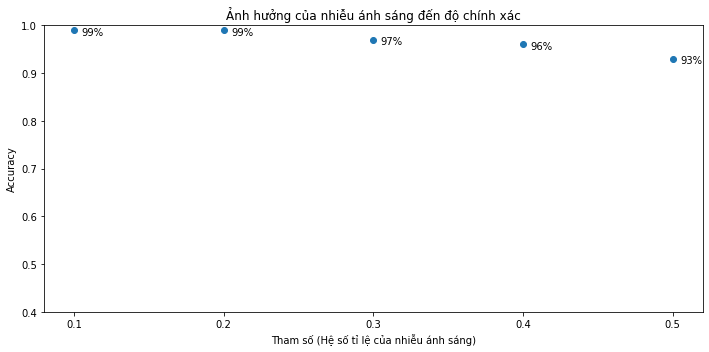

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.title('Ảnh hưởng của nhiễu ánh sáng đến độ chính xác')
plt.rcParams["figure.autolayout"] = True
x = [0.1, 0.2, 0.3, 0.4, 0.5]
y = [0.99, 0.99, 0.97, 0.96, 0.93]
default_x_ticks = range(len(x))
n = ['99%', '99%', '97%', '96%', '93%']
for i, txt in enumerate(n):
    plt.annotate(txt, (default_x_ticks[i]+0.05, y[i]-0.01))
plt.scatter(default_x_ticks, y)
plt.xticks(default_x_ticks, x)
plt.ylim(0.4, 1)
plt.xlabel('Tham số (Hệ số tỉ lệ của nhiễu ánh sáng)')
plt.ylabel('Accuracy')
plt.show()

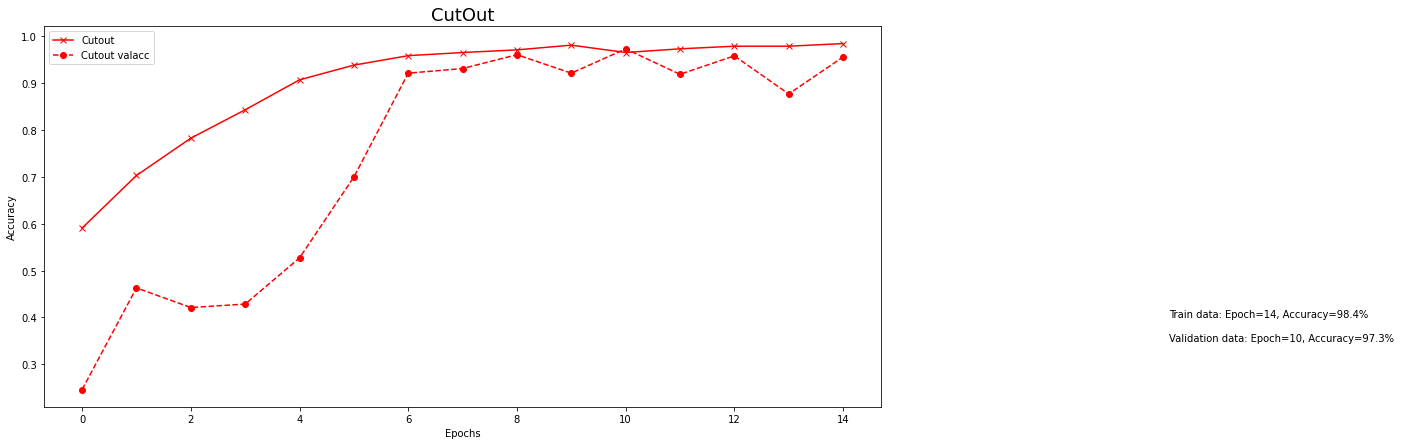

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("CutOut", fontsize=18)
plt.plot(history_5.epoch, history_5.history['accuracy'], label = "Cutout", color='red', marker='x')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], label = "Cutout valacc", color='red', marker='o', linestyle='dashed')

xmax1 = history_5.epoch[np.argmax(history_5.history['accuracy'])]
ymax1 = max(history_5.history['accuracy'])
text= f"Train data: Epoch={xmax1}, Accuracy={round(ymax1, 3)*100}%"
plt.annotate(text, xy=(xmax1, ymax1), xytext=(20,0.4))
xmax2 = history_5.epoch[np.argmax(history_5.history['val_accuracy'])]
ymax2 = max(history_5.history['val_accuracy'])
text= f"Validation data: Epoch={xmax2}, Accuracy={round(ymax2, 3)*100}%"
plt.annotate(text, xy=(xmax2, ymax2), xytext=(20,0.35))

plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

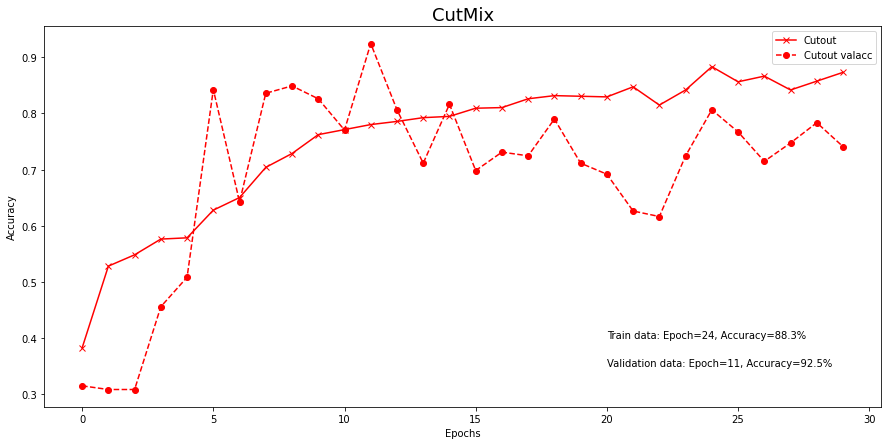

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("CutMix", fontsize=18)
plt.plot(history_6.epoch, history_6.history['accuracy'], label = "Cutout", color='red', marker='x')
plt.plot(history_6.epoch, history_6.history['val_accuracy'], label = "Cutout valacc", color='red', marker='o', linestyle='dashed')

xmax1 = history_6.epoch[np.argmax(history_6.history['accuracy'])]
ymax1 = max(history_6.history['accuracy'])
text= f"Train data: Epoch={xmax1}, Accuracy={round(ymax1, 3)*100}%"
plt.annotate(text, xy=(xmax1, ymax1), xytext=(20,0.4))
xmax2 = history_6.epoch[np.argmax(history_6.history['val_accuracy'])]
ymax2 = max(history_6.history['val_accuracy'])
text= f"Validation data: Epoch={xmax2}, Accuracy={round(ymax2, 3)*100}%"
plt.annotate(text, xy=(xmax2, ymax2), xytext=(20,0.35))

plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

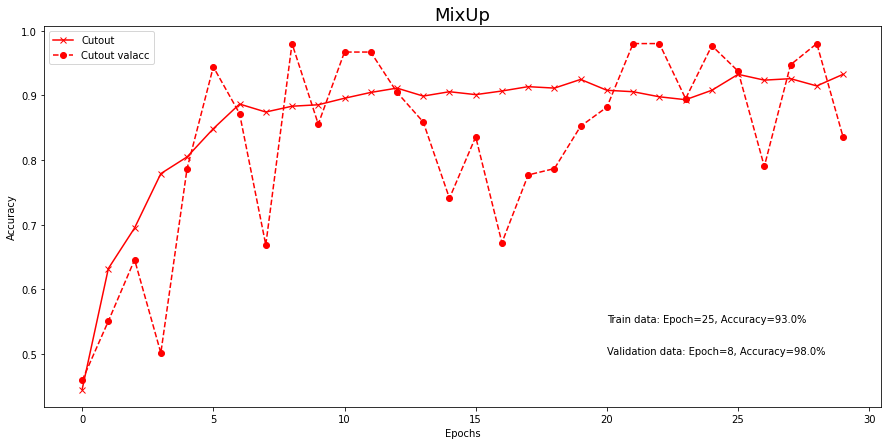

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("MixUp", fontsize=18)
plt.plot(history_7.epoch, history_7.history['accuracy'], label = "Cutout", color='red', marker='x')
plt.plot(history_7.epoch, history_7.history['val_accuracy'], label = "Cutout valacc", color='red', marker='o', linestyle='dashed')

xmax1 = history_7.epoch[np.argmax(history_7.history['accuracy'])]
ymax1 = max(history_7.history['accuracy'])
text= f"Train data: Epoch={xmax1}, Accuracy={round(ymax1, 2)*100}%"
plt.annotate(text, xy=(xmax1, ymax1), xytext=(20,0.55))
xmax2 = history_7.epoch[np.argmax(history_7.history['val_accuracy'])]
ymax2 = max(history_7.history['val_accuracy'])
text= f"Validation data: Epoch={xmax2}, Accuracy={round(ymax2, 2)*100}%"
plt.annotate(text, xy=(xmax2, ymax2), xytext=(20,0.5))

plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

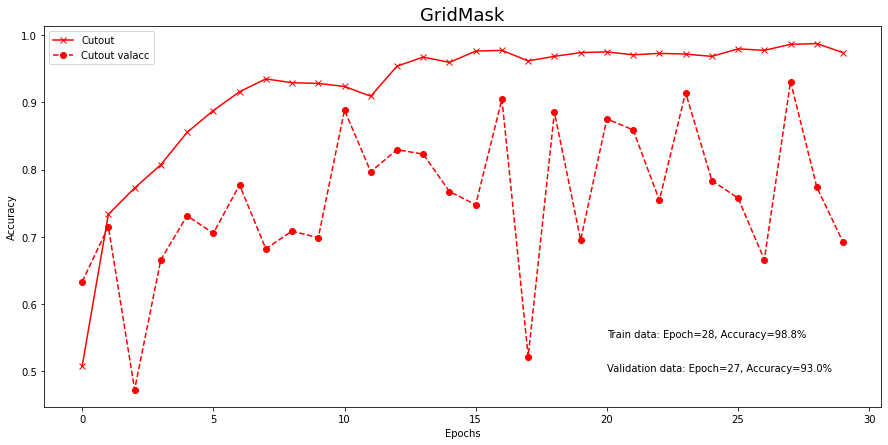

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("GridMask", fontsize=18)
plt.plot(history_8.epoch, history_8.history['accuracy'], label = "Cutout", color='red', marker='x')
plt.plot(history_8.epoch, history_8.history['val_accuracy'], label = "Cutout valacc", color='red', marker='o', linestyle='dashed')

xmax1 = history_8.epoch[np.argmax(history_8.history['accuracy'])]
ymax1 = max(history_8.history['accuracy'])
text= f"Train data: Epoch={xmax1}, Accuracy={round(ymax1, 3)*100}%"
plt.annotate(text, xy=(xmax1, ymax1), xytext=(20,0.55))
xmax2 = history_8.epoch[np.argmax(history_8.history['val_accuracy'])]
ymax2 = max(history_8.history['val_accuracy'])
text= f"Validation data: Epoch={xmax2}, Accuracy={round(ymax2, 2)*100}%"
plt.annotate(text, xy=(xmax2, ymax2), xytext=(20,0.5))

plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

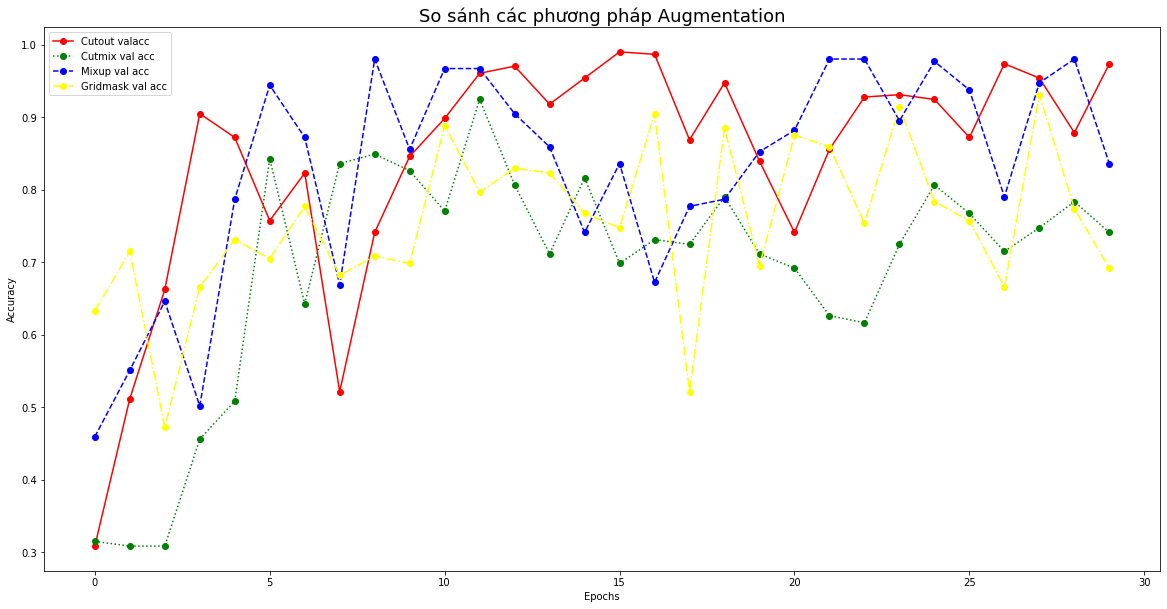

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("So sánh các phương pháp Augmentation", fontsize=18)
# plt.plot(history_5.epoch, history_5.history['accuracy'], label = "Cutout", color='red', marker='x')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], label = "Cutout valacc", color='red', marker='o', linestyle='solid')
# plt.plot(history_6.epoch, history_6.history['accuracy'], label = "Cutmix acc", color='green', marker='x')
plt.plot(history_6.epoch, history_6.history['val_accuracy'], label = "Cutmix val acc", color='green', marker='o', linestyle='dotted')
# plt.plot(history_7.epoch, history_7.history['accuracy'], label = "Mixup acc", color='blue', marker='x')
plt.plot(history_7.epoch, history_7.history['val_accuracy'], label = "Mixup val acc", color='blue', marker='o', linestyle='dashed')
# plt.plot(history_8.epoch, history_8.history['accuracy'], label = "Gridmask acc", color='yellow', marker='x')
plt.plot(history_8.epoch, history_8.history['val_accuracy'], label = "Gridmask val acc", color='yellow', marker='o', linestyle='dashdot')
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend()

In [ ]:
!unzip /mydrive/VGG/resnet_1Ge1D_tiger.zip -d resnet90

In [ ]:
image = cv2.imread('tiger_6_1.png') 
def visualize_features_map(model, img, grid=(4, 4), first=0, last=34):                      #Model truyền vào cần phải là dạng đầu vào là Pretrained model
  last = -(len(model.layers)-last)
  model = Model(inputs=model.layers[first].input, outputs=model.layers[last].output)
  model.summary()

  resize = cv2.resize(img, (224, 224))
  pred = model.predict(np.expand_dims(resize,0))

  num_rows = grid[0]
  num_cols = grid[0] 
  fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(25,25))
  for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
      ax[ax_idx[0], ax_idx[1]].imshow(pred[0,:,:,idx])
visualize_features_map(ResNet50v2, image)

In [ ]:
resnet50_ft_Ga1D = tf.keras.models.load_model('resnet50v2_mix_ver2.h15')
pred = resnet50_ft_Ga1D.predict(valid_ds)
pred = np.argmax(pred,axis=1)

# Map the label
labels = ('background', 'dat', 'meo', 'sai_nhan')
pred = [labels[k] for k in pred]

7/7 [==============================] - 1s 93ms/step


In [ ]:
y_test=[]
for i in valid_ds:
  for j in i[1]:
    y_test.append(np.argmax(j))

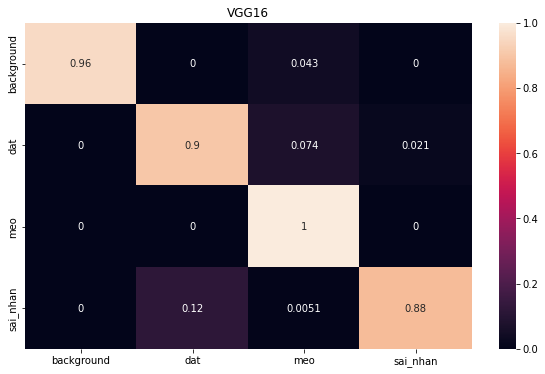

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
y_test = [labels[i] for i in y_test]
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('VGG16')
plt.show()

In [ ]:
# !unzip /mydrive/VGG/FT_VGG_2D2B_95.zip -d FT_VGG_2D2B_95
# new_model = tf.keras.models.load_model('FT_VGG_2D2B_95/content/vgg16_finetune.h15')
new_model = VGG16_with_DataAug

In [ ]:
# print("Evaluate")
# result = new_model.evaluate(Test_data)
# dict(zip(new_model.metrics_names, result))

In [ ]:
!zip -r /mydrive/VGG/Grad_CAM.zip /content/vgg16_randaug+cutout.h15

In [ ]:
def get_img_array(img_path, size):
    array = cv2.imread(img_path)
    plt.imshow(array)
    array = tf.image.resize(array, size)
    array = np.expand_dims(array, axis=0)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

(1, 224, 224, 3)


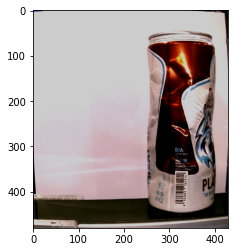

In [ ]:
img_path = 'data2/test/meo/tiger_233_1.png'
img = get_img_array(img_path, (224, 224))
print(img.shape)
# img = get_img_array('test.jpg', (224, 224))
transfer_model = new_model

In [ ]:
print(img.shape)
preds = new_model.predict(img)
preds = np.argmax(preds,axis=1)
preds

(1, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step


array([2])

In [ ]:
transfer_model.layers[-1].activation = None

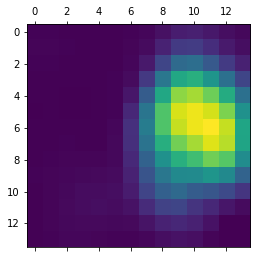

In [ ]:
heatmap = make_gradcam_heatmap(img, transfer_model, "block5_conv3")
heatmap = heatmap
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
image = heatmap
print(heatmap.shape)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = np.expand_dims(image, axis=-1)
print(gray.shape)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

plt.imshow('thresh', thresh)
plt.imshow('image', image)


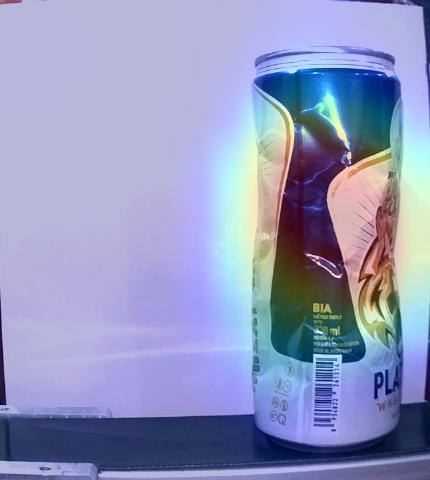

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.image.adjust_brightness(img, -0.2)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
# save_and_display_gradcam('test.jpg', heatmap)

In [ ]:
%tensorboard --logdir logs/fit